In [1]:
from keras.models import Sequential
from keras import layers
from keras.utils import plot_model
from keras import backend as K
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras import optimizers
import tensorflow as tf

Using TensorFlow backend.


# Review: workflow

#### (1) 문제 정의와 데이터셋 수집 
- 무엇을 예측하려 하는가? 이를 예측하기 위한 training data가 있는가? 
- 예측하려는 문제의 종류는 무엇인가?
    - Binary classification
    - Multi-class classification 
    - Regression
- Examples
    - __숫자 손글씨의 인식 (0-9)__
    - 영화 리뷰의 감성 분류 (positive/negative)
    - 얼굴 사진의 감정 인식 (happy/unhappy)
    

#### (2) 성공 지표의 선택
- 최종 모형 비교를 위한 지표 선택 
- Binary classification: accuracy, ROC AUC, precision(=TP/(TP+FP)), recall(=TP/(TP+FN)), F1-measure 등
- Multi-class classification: average precision 등
- Regression: MSE, MAE
- Keras에서 학습 과정의 validation set에 대한 metric으로서 AUC, precision, recall 등을 제공하지 않음(왜? mini-batch에 대한 위의 지표는 오히려 방해가 될 수 있음): Test set에서 계산하는 것이 바람직



#### (3) 평가 방법 선택
- Hold-out validation set 사용
    - Train data의 일정 부분을 validation set으로 사용 
    - 데이터의 양이 많을 때 사용하는 방법
    - `keras.model.fit`의 `validation_data` 또는 `validation_split` option
- K-fold cross-validation
    - Train set을 K-개의 무작위 set으로 구분한 뒤 하나씩 validation set으로 사용하며 반복
    - Hold-out validation set을 구성하기에 데이터가 적을 때 사용  
    - Keras 자체의 cv 모듈이 없으므로 scikit-learn의 `KFold`를 사용 (참고: https://3months.tistory.com/321)


#### (4) 데이터 준비 
- Input data는 일반적으로 [-1,1] 혹은 [0,1] 사이의 데이터로 스케일 조정
- 사용하려는 모델에 맞는 input 형태로 조정
- 필요시 output data 형태 변환(ex. one-hot encoding)

In [12]:
from keras.datasets import mnist
from keras.utils import to_categorical

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

11493376/11490434 [==============================] - 2s 0us/step


#### (5) Baseline보다 나은 모델 훈련 
- 이진분류 라면 정확도 0.5, MNIST 데이터라면 정확도 0.1보다 높은 모형 만들기 
- 적절한 layer 종류의 선택
    - Dense
    - Convolution
    - Dropout
    - Pooling
    - Recurrent
    - Embedding
- 마지막 layer의 activation function 선택
    - output의 형태에 따라 조정
    - Sigmoid, softmax, linear 등
- Loss function 선택
    - 풀고자 하는 문제의 종류에 따라 선택
    - binary_crossentropy, categorical_crossentropy, mse 등
    - 미분 가능해야 하고 주어진 mini-batch에서 계산 가능해야 함. (ROC AUC 등은 사용 불가) 
- Optimizer와 learning rate 선택 
    - rmsprop, adam과 default learning rate 사용이 무난 
    
<img src="figures/cheatsheet_loss.PNG" width="80%">

In [14]:
model = Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_images, train_labels, epochs=10, batch_size=512, validation_split=0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 1s 21us/step - loss: 0.6750 - acc: 0.8122 - val_loss: 0.2746 - val_acc: 0.9219
Epoch 2/10
48000/48000 [==============================] - 1s 16us/step - loss: 0.2316 - acc: 0.9310 - val_loss: 0.1520 - val_acc: 0.9564
Epoch 3/10
48000/48000 [==============================] - 1s 16us/step - loss: 0.1431 - acc: 0.9570 - val_loss: 0.1135 - val_acc: 0.9656
Epoch 4/10
48000/48000 [==============================] - 1s 17us/step - loss: 0.1085 - acc: 0.9671 - val_loss: 0.0975 - val_acc: 0.9709
Epoch 5/10
48000/48000 [==============================] - 1s 17us/step - loss: 0.0903 - acc: 0.9729 - val_loss: 0.0793 - val_acc: 0.9767
Epoch 6/10
48000/48000 [==============================] - 1s 16us/step - loss: 0.0773 - acc: 0.9763 - val_loss: 0.0801 - val_acc: 0.9759
Epoch 7/10
48000/48000 [==============================] - 1s 16us/step - loss: 0.0690 - acc: 0.9798 - val_loss: 0.0689 - val_acc

In [17]:
model.evaluate(test_images, test_labels)

10000/10000 [==============================] - 0s 40us/step


[0.05339451017489191, 0.9825]

In [27]:
test_pred=model.predict(test_images)

#### (6) Scaling up: overfitting 모델 구축 
- 충분한 성능을 나타내는 모델을 만들기 위해 모형을 크게 확장 
    - Layer 추가 
    - 각 layer의 unit 추가 
    - Epoch 수 증가 
- train loss와 validation loss를 모니터 

#### (7) Regularization, hyperparameter tuning 
- 반복적으로 모델 수정, 훈련, 평가하며 모델 튜닝 
    - Dropout 추가 
    - Layer 추가 혹은 제거 
    - L1 또는 L2 penalty 추가 
    - Layer의 unit 수나 learning rate의 튜닝 
  

In [ ]:
model = Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer=optimizers.adam(lr=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

import time 
now = time.strftime("%c")
callbacks_list = [
    TensorBoard(log_dir='./logs/mnist/'+now),
    ModelCheckpoint(filepath='./models/mnist.h5',monitor='val_loss',save_best_only=True)
]

model.fit(train_images, train_labels, epochs=100, batch_size=512, validation_split=0.2, callbacks=callbacks_list)

<font color=darkred>
    
#  Example 4-2. CNN for Hand Signs


손가락으로 숫자를 표현하는 사진들을 학습하여 나타내고 있는 숫자(0-6)를 예측하는 문제를 실습



<img src="figures/SIGNS.png" style="width:800px;height:300px;">



In [2]:
!pip install h5py
#!pip install pillow

In [3]:
from keras.models import Sequential
from keras import layers
from keras.utils import plot_model, to_categorical
from keras import backend as K
from keras.callbacks import EarlyStopping, TensorBoard
from keras import optimizers

import h5py
import numpy as np
import matplotlib.pyplot as plt
#from PIL import Image

### Loading data

In [4]:
train_dataset = h5py.File('data/train_signs.h5', "r")

X_train_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
Y_train_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

test_dataset = h5py.File('data/test_signs.h5', "r")
X_test_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
Y_test_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

classes = np.array(test_dataset["list_classes"][:]) # the list of classes

In [5]:
list(train_dataset.keys())

['list_classes', 'train_set_x', 'train_set_y']

In [6]:
train_dataset["train_set_x"][0].shape

(64, 64, 3)

In [7]:
X_train_orig.shape, Y_train_orig.shape

((1080, 64, 64, 3), (1080,))

In [8]:
X_test_orig.shape, Y_test_orig.shape

((120, 64, 64, 3), (120,))

y = 5


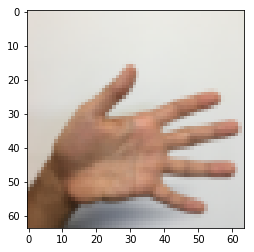

In [9]:
# Example of a picture
index = 0
plt.imshow(X_train_orig[index])
print ("y = " + str(Y_train_orig[index]))

### 데이터 준비

<font color=blue> 
TO DO: 데이터를 모델에 입력하기 적절한 형태로 변환하시오.     

In [10]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = to_categorical(Y_train_orig)
Y_test = to_categorical(Y_test_orig)
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))


number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [11]:
X_val = X_train[:200]
partial_X_train = X_train[200:]

Y_val = Y_train[:200]
partial_Y_train = Y_train[200:]

### Baseline model 구축
<font color="blue">
TO DO: 상대적으로 간단한 layer, activation, loss, optimizer를 사용하여 모형을 구축하고 test accuracy를 통해 성능 확인

In [12]:
K.clear_session()
model = Sequential()
model.add(layers.Conv2D(64, (3,3), strides = 1, padding = "same", input_shape = (64, 64, 3), activation="relu"))
model.add(layers.MaxPool2D((8,8), padding = "same"))
model.add(layers.Conv2D(64, (3,3), strides = 1, padding = "same", activation="relu"))
model.add(layers.MaxPool2D((4,4), padding = "same"))
model.add(layers.Flatten())
model.add(layers.Dense(6, activation="softmax"))

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 1542      
Total params: 40,262
Trainable params: 40,262
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.compile(optimizer = optimizers.adam(lr=0.001), loss = "categorical_crossentropy", metrics  = ['acc'])

In [15]:
model.fit(partial_X_train, partial_Y_train, epochs = 100, batch_size= 64, validation_data=(X_val, Y_val))

Train on 880 samples, validate on 200 samples
Epoch 1/100
880/880 [==============================] - 2s 2ms/step - loss: 1.7994 - acc: 0.1727 - val_loss: 1.7904 - val_acc: 0.1500
Epoch 2/100
880/880 [==============================] - 0s 189us/step - loss: 1.7734 - acc: 0.2318 - val_loss: 1.7595 - val_acc: 0.3000
Epoch 3/100
880/880 [==============================] - 0s 150us/step - loss: 1.7451 - acc: 0.3420 - val_loss: 1.7253 - val_acc: 0.4750
Epoch 4/100
880/880 [==============================] - 0s 168us/step - loss: 1.6942 - acc: 0.3511 - val_loss: 1.6649 - val_acc: 0.4750
Epoch 5/100
880/880 [==============================] - 0s 167us/step - loss: 1.6174 - acc: 0.4682 - val_loss: 1.5667 - val_acc: 0.5050
Epoch 6/100
880/880 [==============================] - 0s 170us/step - loss: 1.4959 - acc: 0.5409 - val_loss: 1.4461 - val_acc: 0.5800
Epoch 7/100
880/880 [==============================] - 0s 159us/step - loss: 1.3416 - acc: 0.6170 - val_loss: 1.3238 - val_acc: 0.5650
Epoch 8/100

Epoch 61/100
880/880 [==============================] - 0s 158us/step - loss: 0.1026 - acc: 0.9795 - val_loss: 0.2945 - val_acc: 0.9150
Epoch 62/100
880/880 [==============================] - 0s 174us/step - loss: 0.1144 - acc: 0.9750 - val_loss: 0.2938 - val_acc: 0.9000
Epoch 63/100
880/880 [==============================] - 0s 157us/step - loss: 0.1267 - acc: 0.9705 - val_loss: 0.3332 - val_acc: 0.8900
Epoch 64/100
880/880 [==============================] - 0s 174us/step - loss: 0.1074 - acc: 0.9727 - val_loss: 0.2833 - val_acc: 0.9150
Epoch 65/100
880/880 [==============================] - 0s 164us/step - loss: 0.1007 - acc: 0.9807 - val_loss: 0.2629 - val_acc: 0.9300
Epoch 66/100
880/880 [==============================] - 0s 168us/step - loss: 0.0794 - acc: 0.9898 - val_loss: 0.2806 - val_acc: 0.9250
Epoch 67/100
880/880 [==============================] - 0s 162us/step - loss: 0.0808 - acc: 0.9898 - val_loss: 0.2577 - val_acc: 0.9200
Epoch 68/100
880/880 [==========================

In [17]:
model.evaluate(X_test, Y_test)

120/120 [==============================] - 0s 451us/step


[0.23187093238035839, 0.9166666626930237]

### Hyperparameter tuning을 통한 모형 수정 

<font color="blue">
TO DO: layer 수, filter 수, learning rate 등을 조정하여 위의 baseline model보다 나은 성능의 model 탐색

In [18]:
def build_model(lr=0.001, nodes=[32,64,128,128]):
    K.clear_session()
    model = Sequential()
    model.add(layers.Conv2D(nodes[0], (3,3), strides = 1, padding = "same", input_shape = (64, 64, 3), activation="relu"))
    model.add(layers.MaxPool2D((8,8), padding = "same"))
    model.add(layers.Conv2D(nodes[1], (3,3), strides = 1, padding = "same", activation="relu"))
    model.add(layers.MaxPool2D((4,4), padding = "same"))
    model.add(layers.Conv2D(nodes[2], (3,3), strides = 1, padding = "same", activation="relu"))
    model.add(layers.MaxPool2D((4,4), padding = "same"))
    model.add(layers.Flatten())
    model.add(layers.Dense(nodes[3], activation="relu"))
    model.add(layers.Dense(6, activation="softmax"))
    model.compile(optimizer = optimizers.adam(lr=lr), loss = "categorical_crossentropy",
                  metrics  = ['acc'])
    return model

In [23]:
np.random.seed(10)
r=-4*np.random.rand(10)
alpha=10**r
alpha

array([8.21707833e-04, 8.26023119e-01, 2.92016277e-03, 1.01107756e-03,
       1.01384590e-02, 1.26128554e-01, 1.61342410e-01, 9.07563771e-04,
       2.10647667e-01, 4.43241834e-01])

In [24]:
from keras.models import load_model

test_acc_all=[]
for i, lr in enumerate(alpha):
    model=build_model(lr=lr)
    callbacks_list = [
        TensorBoard(log_dir='./logs/sign/'+str(lr)),
        ModelCheckpoint(filepath='./models/sign'+str(lr)+'.h5',monitor='val_loss',save_best_only=True)
    ]

    model.fit(partial_X_train, partial_Y_train, epochs = 100, batch_size= 64, validation_data=(X_val, Y_val),
             callbacks=callbacks_list, verbose=0)
    model_best=load_model('./models/sign'+str(lr)+'.h5')
    test_loss, test_acc = model_best.evaluate(X_test, Y_test)
    test_acc_all.append(test_acc)
    print('%d-th learning rate tested: test accuracy %f'%(i, test_acc))
    

120/120 [==============================] - 0s 570us/step
0-th learning rate tested: test accuracy 0.933333
120/120 [==============================] - 0s 570us/step
1-th learning rate tested: test accuracy 0.166667
120/120 [==============================] - 0s 603us/step
2-th learning rate tested: test accuracy 0.900000
120/120 [==============================] - 0s 525us/step
3-th learning rate tested: test accuracy 0.916667
120/120 [==============================] - 0s 568us/step
4-th learning rate tested: test accuracy 0.166667
120/120 [==============================] - 0s 524us/step
5-th learning rate tested: test accuracy 0.166667
120/120 [==============================] - 0s 618us/step
6-th learning rate tested: test accuracy 0.166667
120/120 [==============================] - 0s 567us/step
7-th learning rate tested: test accuracy 0.950000
120/120 [==============================] - 0s 548us/step
8-th learning rate tested: test accuracy 0.166667
120/120 [============================

In [39]:
alpha[np.argsort(test_acc_all)]  ##  lr의 범위가 적절하지 않은 값을 많이 포함하고 있음. test acc기준 오름차순으로 learning rate를 정렬

array([8.26023119e-01, 1.01384590e-02, 1.26128554e-01, 1.61342410e-01,
       2.10647667e-01, 4.43241834e-01, 2.92016277e-03, 1.01107756e-03,
       8.21707833e-04, 9.07563771e-04])

In [48]:
## alpha의 범위를 10^(-3)-10^(-4)로 좁혀서 다시 탐색
np.random.seed(10)
r=-np.random.rand(10)-3
alpha=10**r
alpha

array([0.00016931, 0.00095334, 0.00023246, 0.00017832, 0.00031732,
       0.00059594, 0.00063378, 0.00017357, 0.00067747, 0.00081594])

In [49]:
from keras.models import load_model

test_acc_all=[]
for i, lr in enumerate(alpha):
    model=build_model(lr=lr)
    callbacks_list = [
        TensorBoard(log_dir='./logs/sign/'+str(lr)),
        ModelCheckpoint(filepath='./models/sign'+str(lr)+'.h5',monitor='val_loss',save_best_only=True)
    ]

    model.fit(partial_X_train, partial_Y_train, epochs = 100, batch_size= 64, validation_data=(X_val, Y_val),
             callbacks=callbacks_list, verbose=0)
    model_best=load_model('./models/sign'+str(lr)+'.h5')
    test_loss, test_acc = model_best.evaluate(X_test, Y_test)
    test_acc_all.append(test_acc)
    print('%d-th learning rate tested: test accuracy %f'%(i, test_acc))
    

120/120 [==============================] - 0s 586us/step
0-th learning rate tested: test accuracy 0.891667
120/120 [==============================] - 0s 595us/step
1-th learning rate tested: test accuracy 0.925000
120/120 [==============================] - 0s 574us/step
2-th learning rate tested: test accuracy 0.900000
120/120 [==============================] - 0s 589us/step
3-th learning rate tested: test accuracy 0.875000
120/120 [==============================] - 0s 646us/step
4-th learning rate tested: test accuracy 0.933333
120/120 [==============================] - 0s 572us/step
5-th learning rate tested: test accuracy 0.958333
120/120 [==============================] - 0s 748us/step
6-th learning rate tested: test accuracy 0.958333
120/120 [==============================] - 0s 555us/step
7-th learning rate tested: test accuracy 0.908333
120/120 [==============================] - 0s 571us/step
8-th learning rate tested: test accuracy 0.941667
120/120 [============================

In [50]:
np.argmax(test_acc_all) # 5번째 lr이 최대 test accuracy를 제공 

5

### 나의 사진 테스트

<font color="blue">

TO DO: 
    본인의 손가락으로 숫자를 표현하는 사진을 찍어 jpg형태로 저장한 후 figures folder에 업로드하고 아래의 코드를 실행하여 사진을 모형에 입력가능한 형태로 변환하시오. 변환된 사진을 학습된 모형에 입력하여 분류 결과를 확인하시오. 

In [51]:
final_model=load_model('./models/sign'+str(alpha[5])+'.h5')

class: 3


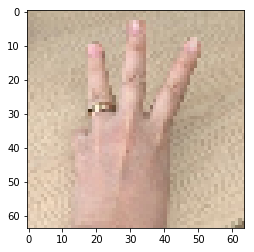

In [56]:
from keras.preprocessing import image 

img_path = 'figures/myhand3.jpg'
img = image.load_img(img_path, target_size=(64, 64))
plt.imshow(img)

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x/255.

pred=final_model.predict_classes(x)
print('class: %d'%(pred))

References
- https://www.coursera.org/specializations/deep-learning